# Python Trainer
# Group 3 Project
#### Ryan Walsh, Nico Gomez,


### Environment Instructions
> conda create -n ece594_g3 -c conda-forge numpy scipy matplotlib opencv torchvision torch kaggle huggingface_hub notebook jupyter ipykernel

### Setup Kaggle API (For dataset download)


### Import Libraries

In [79]:
import argparse, sys, os, pathlib, shutil, math, time, multiprocessing, json, importlib, random, collections, io, dataclasses
import typing as typ
import torchvision, torchvision.datasets
import numpy as np
import torch, torch.nn, torch.optim, torch.nn.functional
# import huggingface_hub, kaggle

import matplotlib.pyplot as plt

#### Find Root Path

In [80]:
def get_project_root() -> pathlib.Path:
    """
    Return the project root (the folder that contains 'python' and 'data' ideally).
    If running this notebook from <repo>/python or inside it, we go up one level.
    Fallback: if current directory already looks like project root (has data/), use it.
    """
    cwd: pathlib.Path = pathlib.Path.cwd().resolve()
    if cwd.name == "python" and (cwd.parent / "data").exists():
        return cwd.parent
    for path in [cwd] + list(cwd.parents):
        if (path / "data").exists() or (path / "python").exists():
            return path
    return cwd

PROJECT_ROOT: pathlib.Path = get_project_root()
DATA_ROOT: pathlib.Path = PROJECT_ROOT / "data"
DATA_ROOT.mkdir(parents=True, exist_ok=True) # Force data folder to exist

print(f"project_root = {PROJECT_ROOT}")
print(f"data_root    = {DATA_ROOT}")


project_root = /home/walden95/Documents/UIC/esp32_cnn-main
data_root    = /home/walden95/Documents/UIC/esp32_cnn-main/data


### Load Datasets

In [81]:
def get_torchvision_transform(to_10x10: bool = True, grayscale: bool = False):
    ops: list = []
    if grayscale:
        ops.append(torchvision.transforms.Grayscale(num_output_channels=1))
    if to_10x10:
        ops.append(torchvision.transforms.Resize(
            (10, 10),
            interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
        )
    ops.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(ops)

def load_dataset(
    name: typ.Literal["mnist", "emnist", "kmnist", "fashion", "chinese", "qmnist", "k49"] = "emnist",
    split: typ.Literal["byclass", "bymerge", "balanced", "letters", "digits", "mnist", "train", "test"] = "balanced",
    project_root: pathlib.Path = PROJECT_ROOT,
    download_if_missing: bool = True,
    chinese_root: pathlib.Path|None = None
):
    """
    Returns (train_dataset, test_dataset, num_classes, class_names)
    Looks under PROJECT_ROOT/data/<DatasetName>
    """
    name = name.lower()
    data_root: pathlib.Path = project_root / "data"
    class_names: list[str]

    if name in {"mnist", "kmnist", "emnist", "fashion", "qmnist"}:
        transform = get_torchvision_transform(to_10x10=True, grayscale=False)
        if name == "mnist":
            train = torchvision.datasets.MNIST(str(data_root / "MNIST"), train=True, download=download_if_missing, transform=transform)
            test = torchvision.datasets.MNIST(str(data_root / "MNIST"), train=False, download=download_if_missing, transform=transform)
            class_names = [str(i) for i in range(10)]
        elif name == "fashion":
            train = torchvision.datasets.FashionMNIST(str(data_root / "FashionMNIST"), train=True, download=download_if_missing, transform=transform)
            test = torchvision.datasets.FashionMNIST(str(data_root / "FashionMNIST"), train=False, download=download_if_missing, transform=transform)
            class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
        elif name == "kmnist":
            train = torchvision.datasets.KMNIST(str(data_root / "KMNIST"), train=True, download=download_if_missing, transform=transform)
            test = torchvision.datasets.KMNIST(str(data_root / "KMNIST"), train=False, download=download_if_missing, transform=transform)
            # class_names = ["お (o)","き (ki)", "す (su)","つ (tsu)","な (na)","は (ha)","ま (ma)","や (ya)","れ (re)","を (wo)"]
            class_names = ["o", "ki", "su", "tsu", "na", "ha", "ma", "ya", "re", "wo"]
        elif name == "qmnist":
            # torchvision QMNIST uses 'what' argument ('train'|'test'|'nist')
            try:
                train = torchvision.datasets.QMNIST(str(data_root / "QMNIST"), what="train", download=download_if_missing, transform=transform)
                test = torchvision.datasets.QMNIST(str(data_root / "QMNIST"), what="test", download=download_if_missing, transform=transform)
            except TypeError: # fallback for older torchvision that uses 'train' bool
                train = torchvision.datasets.QMNIST(str(data_root / "QMNIST"), train=True, download=download_if_missing, transform=transform)
                test = torchvision.datasets.QMNIST(str(data_root / "QMNIST"), train=False, download=download_if_missing, transform=transform)
            class_names = [str(i) for i in range(10)]
        else: # emnist (supports 10/26/47/62 classes via split)
            train = torchvision.datasets.EMNIST(str(data_root / "EMNIST"), split=split, train=True, download=download_if_missing, transform=transform)
            test = torchvision.datasets.EMNIST(str(data_root / "EMNIST"), split=split, train=False, download=download_if_missing, transform=transform)
            class_names = [str(i) for i in range(10)]
            if split == "digits":
                class_names = [str(i) for i in range(10)]
            if split == "letters":
                class_names = [chr(ord('a') + i) for i in range(26)] # a..z
            if split == "byclass":
                digits: list[str] = [str(i) for i in range(10)]
                upper: list[str] = [chr(ord("A") + i) for i in range(26)]
                lower : list[str] = [chr(ord("a") + i) for i in range(26)]
                class_names = digits + upper + lower # 62
            if split in {"bymerge", "balanced"}:
                class_names = [f"class_{i:02d}" for i in range(47)]  # Official merged label set is nontrivial; provide stable index names.
        
        num_classes: int = len(class_names)
        return train, test, num_classes, class_names

    if name in {"chinese", "k49"}:  # ImageFolder datasets
        transform = get_torchvision_transform(to_10x10=True, ImageFoldergrayscale=True)

        # Candidate roots
        cands: list[pathlib.Path] = []
        if chinese_root is not None and name == "chinese":
            cands.append(pathlib.Path(chinese_root))

        base: pathlib.Path = data_root / ("ChineseMNIST" if name == "chinese" else "K49")  # <-- K49 folder
        cands += [base, base/"data", base/"images", base/"dataset"]

        chosen = None
        for r in cands:
            try:
                if r.exists() and any((r/child).is_dir() for child in os.listdir(r) if not child.startswith(".")):
                    chosen = r
                    break
            except Exception:
                pass
        if chosen is None:
            raise RuntimeError(
                f"{name.upper()} not found with class-subfolder layout. Tried:\n  " + "\n  ".join(str(p) for p in cands)
            )

        full: torchvision.datasets.ImageFolder = torchvision.datasets.ImageFolder(str(chosen), transform=transform)
        class_names: list[str] = list(full.classes)
        num_classes: int = len(class_names)

        # Deterministic 80/20 split per class
        idx_by_cls = collections.defaultdict(list)
        for idx, (_, y) in enumerate(full.samples):
            idx_by_cls[y].append(idx)
        train_idx, test_idx = [], []
        for y, idxs in idx_by_cls.items():
            idxs = sorted(idxs)
            k = max(1, int(0.8 * len(idxs)))
            train_idx += idxs[:k]
            test_idx  += idxs[k:]
        return torch.utils.data.Subset(full, train_idx), torch.utils.data.Subset(full, test_idx), num_classes, class_names

    raise ValueError("dataset must be one of: 'mnist', 'kmnist', 'fashion', 'emnist', 'chinese'")


#### Model Defintion
Activation and MLP Defintitions

In [82]:
# Activations
def make_activation(name: str) -> torch.nn.Module:
    name: str = name.lower()
    if name == "relu":
        return torch.nn.ReLU()
    if name == "elu":
        return torch.nn.ELU()
    if name == "gelu":
        return torch.nn.GELU()
    if name in ("swish", "silu"):
        return torch.nn.SiLU()
    if name in ("leaky-relu", "leaky_relu", "lrelu"):
        return torch.nn.LeakyReLU(0.01)
    raise ValueError(f"Unsupported activation: {name}")

# Quantization (fake/simulated)
class UniformFakeQuant(torch.nn.Module):
    """
    Simple per-tensor symmetric/asymmetric uniform fake-quantizer.

    If bits is None or <=0, it is a no-op.
    For signed=True: values in [-amax, amax] mapped to int range [-Q, Q], Q=2^(bits-1)-1
    For signed=False: values in [0, amax] mapped to [0, 2^bits-1]
    """
    def __init__(self, bits: typ.Optional[int], signed: bool = True, eps: float = 1e-8):
        super().__init__()
        self.bits: int|None = bits if (bits is not None and bits > 0) else None
        self.signed: bool = signed
        self.eps: float = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.bits is None:
            return x
        
        if self.signed:
            qmax: int = (1 << (self.bits - 1)) - 1
            # stats from detached tensor (no grad through range estimate)
            amax: torch.Tensor = x.detach().abs().max().clamp(min=self.eps)
            scale: torch.Tensor = amax / qmax
            x_int: torch.Tensor = torch.clamp(torch.round(x / scale), -qmax - 1, qmax)
            x_q: torch.Tensor = x_int * scale
            # STE: forward = x_q, backward = identity
            return x + (x_q - x).detach()
        else:
            qmax_u: int = (1 << self.bits) - 1
            x_det: torch.Tensor = x.detach()
            amin: torch.Tensor = x_det.min()
            amax: torch.Tensor = x_det.max()
            rng: torch.Tensor = (amax - amin).clamp(min=self.eps)
            scale_u: torch.Tensor = rng / qmax_u
            x_int_u: torch.Tensor = torch.clamp(torch.round((x - amin) / scale_u), 0, qmax_u)
            x_q: torch.Tensor = x_int_u * scale_u + amin
            return x + (x_q - x).detach()

def quantize_weights_tensor(w: torch.Tensor, bits: int, signed: bool = True) -> typ.Tuple[torch.Tensor, float, int]:
    """
    Offline helper to produce integer weights and scale for deployment.
    Returns (w_int, scale, zero_point). Here zero_point is 0 for signed symmetric.
    """
    if bits <= 0:
        raise ValueError("bits must be >= 1")
    
    qmax: int
    amax: int
    rng: float
    scale: float
    w_int: int
    zero_point: int

    if signed:
        qmax = (1 << (bits - 1)) - 1
        amax = w.abs().max().item() if w.numel() > 0 else 0.0
        amax = max(amax, 1e-8)
        scale = amax / qmax
        w_int = torch.clamp(torch.round(w / scale), -qmax - 1, qmax).to(torch.int32)
        zero_point = 0
        return w_int, scale, zero_point
    else:
        qmax = (1 << bits) - 1
        wmin = float(w.min().item()) if w.numel() > 0 else 0.0
        wmax  = float(w.max().item()) if w.numel() > 0 else 0.0
        rng = max(wmax - wmin, 1e-8)
        scale = rng / qmax
        w_int = torch.clamp(torch.round((w - wmin) / scale), 0, qmax).to(torch.int32)
        zero_point = int(round(-wmin / scale))
        return w_int, scale, zero_point


In [83]:
class QuantizedMLP(torch.nn.Module):
    """
    Flexible MLP with:
      - layer_sizes: e.g., [100, 32, 16, 10]  (input_dim=100 fixed for 10x10 images)
      - activations:  either a single name or list per hidden layer (len = len(layer_sizes)-2)
      - weight_bits:  list of Optional[int] per Linear (len = len(layer_sizes)-1), None => float
      - activation_bits:     list of Optional[int] per activation (len = len(layer_sizes)-2), None => float
      - bias:         default False to mirror the ESP32 project
    We use fake quantization at runtime: weights are quantized on-the-fly for matmul,
    activations are quantized after each nonlinearity.
    """
    def __init__(
        self,
        layer_sizes: list[int],
        activations: str|list[str] = "relu",
        weight_bits: list[int|None]|None = None,
        activation_bits: list[int|None]|None  = None,
        bias: bool = False,
    ):
        super().__init__()
        assert len(layer_sizes) >= 2, "layer_sizes must include input and output dims"
        self.layer_sizes = layer_sizes

        # Build Linear layers
        linear_modules: list[torch.nn.Module] = []
        for in_f, out_f in zip(layer_sizes[:-1], layer_sizes[1:]):
            linear_modules.append(torch.nn.Linear(in_f, out_f, bias=bias))
        self.linear_modules = torch.nn.ModuleList(linear_modules)

        # Activations between linears except after last
        n_hidden: int = len(layer_sizes) - 2
        activation_modules: list[torch.nn.Module]
        if isinstance(activations, str):
            activation_modules = [make_activation(activations) for _ in range(n_hidden)]
        else:
            assert len(activations) == n_hidden, "len(activations) must equal #hidden layers"
            activation_modules = [make_activation(a) for a in activations]
        self.activation_modules = torch.nn.ModuleList(activation_modules)

        # Fake quantizers
        if weight_bits is None:
            weight_bits = [None] * (len(layer_sizes) - 1)
        if activation_bits is None:
            activation_bits = [None] * (len(layer_sizes) - 2)
        assert len(weight_bits) == len(self.linear_modules), "weight_bits length mismatch"
        assert len(activation_bits) == len(self.activation_modules), "act_bits length mismatch"

        self.wquants: torch.nn.ModuleList = torch.nn.ModuleList([UniformFakeQuant(bits=b, signed=True) for b in weight_bits])
        self.aquants: torch.nn.ModuleList = torch.nn.ModuleList([UniformFakeQuant(bits=b, signed=True) for b in activation_bits])
        self.flatten: torch.nn.Flatten = torch.nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B,1,10,10] -> [B,100]
        x = self.flatten(x)
        for i, linear in enumerate(self.linear_modules):
            # quantize weights on-the-fly
            wq: torch.Tensor = self.wquants[i](linear.weight)
            # use F.linear with quantized weight, no bias
            x = torch.nn.functional.linear(x, wq, linear.bias)
            if i < len(self.activation_modules):
                x = self.activation_modules[i](x)
                x = self.aquants[i](x)  # quantize activation
        return x

def make_mlp(
        num_classes: int,
        depth: int = 2,
        width: int|list[int] = 32,
        activations: str|list[str] = "relu",
        weight_bits: list[int|None]|None = None,
        activation_bits: list[int|None]|None = None,
        bias: bool = False,
    ) -> QuantizedMLP:
    """
    Convenience: input_dim fixed to 100 (10x10). Build [100] + hidden + [num_classes].
    depth: number of hidden layers
    width: single int or list[int] of length = depth
    """
    input_dim: int = 100
    hidden: list[int] = [width] * depth if isinstance(width, int) else list(width)
    assert len(width) == depth, "width list length must equal depth"
    layer_sizes: list[int] = [input_dim] + hidden + [num_classes]

    # default bits: None => float for all
    if weight_bits is None:
        weight_bits = [None] * (len(layer_sizes) - 1)
    if activation_bits is None:
        activation_bits = [None] * (len(layer_sizes) - 2)

    return QuantizedMLP(
        layer_sizes=layer_sizes,
        activations=activations,
        weight_bits=weight_bits,
        activation_bits=activation_bits,
        bias=bias,
    )

#### CheckPoint Manager
Utility for recording model training information

In [84]:
def _fqcn(cls: type) -> str:
    return f"{cls.__module__}.{cls.__qualname__}"

class CheckpointManager:
    """
    Tracks & saves:
      • best_train  → min train_loss
      • best_val    → min val_loss
      • best_combo  → min (train_loss + val_loss)
      • last        → last state at end of training

    Also:
      • per-epoch CSV ('loss_history.csv') and JSONL checkpoint log
      • optional subfolder per run via run_id
      • optional cleanup on init
      • atomic saves (temp file + Path.replace)
      • optional 'model_obj' (entire pickled model) for quick restore
      • stores model metadata + optional kwargs for rebuild

    Args:
      root_path: base folder for checkpoints/logs
      run_id: optional subfolder name for this run (e.g., '2025-08-15_12-00-01')
      wipe_on_start: if True, remove old files in the target folder on init
      append_history: if False, start a fresh CSV header (ignored if file is wiped)
      store_entire_model: also pickle the model object as 'model_obj' (bigger files)
      model_kwargs: optional constructor kwargs to rebuild model if 'model_obj' isn't present
      seed: optional random seed to stamp into metadata
    """

    def __init__(
        self,
        root_path: str|pathlib.Path,
        run_id: str|None = None,
        wipe_on_start: bool = True,
        append_history: bool = True,
        store_entire_model: bool = True,
        model_kwargs: dict[str, typ.Any]|None = None,
        seed: int|None = None,
    ) -> None:
        root: pathlib.Path = pathlib.Path(root_path)
        self.save_dir: pathlib.Path = (root / run_id) if run_id else root
        self.save_dir.mkdir(parents=True, exist_ok=True)

        self.store_entire_model: bool = store_entire_model
        self.model_kwargs: dict[str, typ.Any]|None = model_kwargs
        self.seed: int|None = seed

        # File paths
        self.paths: dict[str, pathlib.Path] = {
            "best_train": self.save_dir / "best_train.pt",
            "best_val": self.save_dir / "best_val.pt",
            "best_combo": self.save_dir / "best_combo.pt",
            "last": self.save_dir / "last.pt",
        }
        self.log_path: pathlib.Path = self.save_dir / "checkpoints_log.jsonl"
        self.history_csv_path: pathlib.Path = self.save_dir / "loss_history.csv"

        # Optional clean slate
        if wipe_on_start:
            for p in (*self.paths.values(), self.log_path, self.history_csv_path):
                try:
                    if p.exists():
                        p.unlink()
                except Exception:
                    pass

        self._history_csv_initialized: bool = append_history and self.history_csv_path.exists()

        # Bests
        self.best_train: float|None = None
        self.best_val: float|None = None
        self.best_combo: float|None = None

        # In-memory history
        self.history: list[dict[str, float]] = []

    # ---------- helpers ----------
    @staticmethod
    def _is_better(candidate: float, best: float | None) -> bool:
        if candidate != candidate:  # NaN
            return False
        return best is None or candidate < best

    def _build_model_meta(self, model: torch.nn.Module) -> dict[str, typ.Any]:
        try:
            param_count = int(sum(p.numel() for p in model.parameters()))
        except Exception:
            param_count = -1
        meta: dict[str, typ.Any] = {
            "model_class": model.__class__.__name__,
            "model_fqcn": _fqcn(model.__class__),
            "model_param_count": param_count if param_count >= 0 else None,
            "seed": self.seed,
        }
        if self.model_kwargs is not None:
            meta["model_kwargs"] = self.model_kwargs
        return meta

    @staticmethod
    def _state_dict(
        model: torch.nn.Module,
        optimizer: torch.optim.Optimizer|None,
        scheduler: torch.optim.lr_scheduler._LRScheduler|None,
        epoch: int,
        metrics: dict[str, float],
        history: list[dict[str, float]],
        extra: dict[str, typ.Any]|None,
        *,
        store_entire_model: bool,
        meta: dict[str, typ.Any],
    ) -> dict[str, typ.Any]:
        state: dict[str, typ.Any] = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict() if optimizer is not None else None,
            "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
            "metrics": metrics,
            "history": history.copy(),
            "rng_state": {
                "torch": torch.get_rng_state(),
                "cuda": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else [],
            },
            "timestamp": time.time(),
            "extra": {**(extra or {}), **meta},
        }
        if store_entire_model:
            state["model_obj"] = model
        return state

    def _append_to_log_jsonl(self, tag: str, epoch: int, metrics: dict[str, float], path: pathlib.Path) -> None:
        log_line: dict[str, typ.Any] = {
            "time": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
            "tag": tag,
            "epoch": epoch,
            "metrics": metrics,
            "path": str(path),
        }
        with self.log_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(log_line) + "\n")

    def _atomic_save(self, obj: dict[str, typ.Any], target_path: pathlib.Path, retries: int = 5, base_delay: float = 0.15) -> None:
        """
        Write to a temp file in the same directory, then atomically replace target.
        Retries on transient errors; falls back to unique filename if needed.
        """
        tmp_path: pathlib.Path = target_path.with_suffix(target_path.suffix + f".tmp.{os.getpid() if 'os' in globals() else '0'}")
        last_err: Exception|None = None
        for attempt in range(retries):
            try:
                torch.save(obj, tmp_path)
                # Path.replace is atomic on POSIX and Windows when same filesystem
                tmp_path.replace(target_path)
                return
            except Exception as e:
                last_err = e
                time.sleep(base_delay * (2 ** attempt))
            finally:
                try:
                    if tmp_path.exists():
                        tmp_path.unlink()
                except Exception:
                    pass
        # Fallback
        fallback: pathlib.Path = target_path.with_name(target_path.stem + f".fallback_{int(time.time())}" + target_path.suffix)
        torch.save(obj, fallback)
        self._append_to_log_jsonl(tag="atomic_save_fallback", epoch=-1, metrics={}, path=fallback)
        if last_err:
            print(f"Atomic save retry exhausted for {target_path}. Wrote fallback {fallback}. Error: {last_err}")

    # ---------- public save API ----------
    def _save(
        self,
        tag: str,
        model: torch.nn.Module,
        optimizer: torch.optim.Optimizer | None,
        scheduler: torch.optim.lr_scheduler._LRScheduler | None,
        epoch: int,
        metrics: dict[str, float],
        extra: dict[str, typ.Any] | None = None,
    ) -> None:
        path: pathlib.Path = self.paths[tag]
        meta: dict[str, typ.Any] = self._build_model_meta(model)
        state: dict[str, typ.Any] = self._state_dict(
            model, optimizer, scheduler, epoch, metrics, self.history, extra,
            store_entire_model=self.store_entire_model, meta=meta,
        )
        self._atomic_save(state, path)
        self._append_to_log_jsonl(tag=tag, epoch=epoch, metrics=metrics, path=path)

    def log_epoch(self, epoch: int, train_loss: float, val_loss: float, extra: dict[str, float]|None = None) -> None:
        train_loss = float(torch.nan_to_num(torch.tensor(train_loss), nan=torch.inf).item())
        val_loss = float(torch.nan_to_num(torch.tensor(val_loss), nan=torch.inf).item())
        combo_loss: float = train_loss + val_loss
        row: dict[str, float] = {
            "epoch": float(epoch),
            "train_loss": train_loss,
            "val_loss": val_loss,
            "combo_loss": combo_loss,
        }
        if extra:
            for k, v in extra.items():
                try:
                    row[k] = float(v)
                except Exception:
                    pass
        self.history.append(row)
        self._write_history_csv(row)

    def _write_history_csv(self, row: dict[str, float]) -> None:
        columns: list[str] = sorted(row.keys(), key=lambda k: (k != "epoch", k))
        write_header: bool = not self._history_csv_initialized or not self.history_csv_path.exists()
        with self.history_csv_path.open("a", encoding="utf-8") as file:
            if write_header:
                file.write(",".join(columns) + "\n")
                self._history_csv_initialized = True
            values: list[str] = [str(row.get(col, "")) for col in columns]
            file.write(",".join(values) + "\n")

    def update_and_maybe_save(
        self,
        model: torch.nn.Module,
        optimizer: torch.optim.Optimizer|None,
        scheduler: torch.optim.lr_scheduler._LRScheduler|None,
        epoch: int,
        train_loss: float,
        val_loss: float,
        extra: dict[str, typ.Any]|None = None,
    ) -> None:
        self.log_epoch(epoch, train_loss, val_loss, extra=extra or {})
        combo: float = self.history[-1]["combo_loss"]
        metrics: dict[str, float] = {
            "train_loss": self.history[-1]["train_loss"],
            "val_loss": self.history[-1]["val_loss"],
            "combo_loss": combo,
        }
        if self._is_better(metrics["train_loss"], self.best_train):
            self.best_train = metrics["train_loss"]
            self._save("best_train", model, optimizer, scheduler, epoch, metrics, extra)
        if self._is_better(metrics["val_loss"], self.best_val):
            self.best_val = metrics["val_loss"]
            self._save("best_val", model, optimizer, scheduler, epoch, metrics, extra)
        if self._is_better(combo, self.best_combo):
            self.best_combo = combo
            self._save("best_combo", model, optimizer, scheduler, epoch, metrics, extra)

    def save_last(
        self,
        model: torch.nn.Module,
        optimizer: torch.optim.Optimizer|None,
        scheduler: torch.optim.lr_scheduler._LRScheduler|None,
        epoch: int,
        last_metrics: dict[str, float],
        extra: dict[str, typ.Any]|None = None,
    ) -> None:
        clean_metrics: dict[str, float] = {}
        for k, v in last_metrics.items():
            try:
                clean_metrics[k] = float(torch.nan_to_num(torch.tensor(v)).item())
            except Exception:
                continue
        self._save("last", model, optimizer, scheduler, epoch, clean_metrics, extra)

    # ---------- loading helpers ----------
    @staticmethod
    def load_checkpoint(path: str|pathlib.Path, map_location: str|torch.device = "cpu") -> tuple[dict, torch.nn.Module|None]:
        p: pathlib.Path = pathlib.Path(path)
        state: dict = torch.load(p, map_location=map_location)
        model: torch.nn.Module | None = state.get("model_obj", None)
        return state, model

    @staticmethod
    def load_model(path: str|pathlib.Path, map_location: str|torch.device = "cpu", strict: bool = True) -> tuple[dict, torch.nn.Module]:
        p: pathlib.Path = pathlib.Path(path)
        state: dict = torch.load(p, map_location=map_location)
        if "model_obj" in state and state["model_obj"] is not None:
            model: torch.nn.Module = state["model_obj"]
            try:
                model.load_state_dict(state["model_state"], strict=strict)
            except Exception:
                pass
            return state, model
        extra: dict[str, typ.Any] = state.get("extra", {}) or {}
        fqcn: str|None = extra.get("model_fqcn", None)
        kwargs: dict[str, typ.Any] | None = extra.get("model_kwargs", None)
        if fqcn and isinstance(kwargs, dict):
            module_name, class_name = fqcn.rsplit(".", 1)
            mod = importlib.import_module(module_name)
            cls = getattr(mod, class_name)
            model = cls(**kwargs)
            model.load_state_dict(state["model_state"], strict=strict)
            return state, model
        raise RuntimeError("Checkpoint missing model object and rebuild metadata.")

#### Header Exporter

In [85]:
# Map activation modules to stable names for the header
def activation_name(act: torch.nn.Module) -> str:
    t = type(act).__name__.lower()
    if t in {"relu"}: return "relu"
    if t in {"elu"}: return "elu"
    if t in {"gelu"}: return "gelu"
    if t in {"silu"}: return "swish"   # SiLU is swish
    if t in {"leakyrelu"}: return "leaky_relu"
    return t  # fallback

@dataclasses.dataclass
class ExportSpec:
    layer_in_dims: list[int] # e.g. [100, 32, 16]
    layer_out_dims: list[int] # e.g. [32, 16, 10]
    weight_bits: list[int|None] # per Linear
    act_bits: list[int|None] # per hidden activation
    activations: list[str] # per hidden activation
    bias: bool
    num_layers: int
    num_classes: int

def collect_export_spec(model: torch.nn.Module, num_classes: int) -> ExportSpec:
    # Assumes QuantizedMLP shape: self.linears, self.acts, self.wquants, self.aquants
    linear_modules: list[torch.nn.Linear] = list(model.linear_modules)
    activation_modules: list[torch.nn.Module] = list(model.activation_modules)

    in_dims: list[int] = [lin.in_features for lin in linear_modules]
    out_dims: list[int] = [lin.out_features for lin in linear_modules]

    wbits: list[int|None] = [getattr(q, "bits", None) for q in model.wquants]
    abits: list[int|None] = [getattr(q, "bits", None) for q in model.aquants]
    anames: list[str] = [activation_name(a) for a in activation_modules]

    return ExportSpec(
        layer_in_dims=in_dims,
        layer_out_dims=out_dims,
        weight_bits=wbits,
        act_bits=abits,
        activations=anames,
        bias=any(lin.bias is not None for lin in linear_modules),
        num_layers=len(linear_modules),
        num_classes=num_classes,
    )


In [86]:
def _write_array_c(file: io.TextIOBase, ctype: str, name: str, arr: typ.Iterable, cols: int = 10, trailer: str = ";\n") -> None:
    file.write(f"const {ctype} {name}[] = {{\n  ")
    for i, v in enumerate(arr):
        file.write(f"{v}")
        if i != -1:
            file.write(", ")
        if (i + 1) % cols == 0:
            file.write("\n  ")
    file.seek(file.tell() - 2)  # trim last ", "
    file.write(f"\n}}{trailer}")

def export_header_float(model: torch.nn.Module, spec: ExportSpec, out_path: pathlib.Path, header_guard: str = "ESP32_MLP_WEIGHTS_H") -> pathlib.Path:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with out_path.open("w", encoding="utf-8") as file:
        file.write(f"#ifndef {header_guard}\n#define {header_guard}\n\n")
        file.write("// FLOAT weights (no biases) + architecture metadata\n\n")
        file.write(f"#define NUM_LAYERS {spec.num_layers}\n")
        file.write(f"#define NUM_CLASSES {spec.num_classes}\n\n")

        # dims
        file.write("static const int16_t NN_IN_DIMS[NUM_LAYERS]  = {")
        file.write(",".join(str(x) for x in spec.layer_in_dims)); file.write("};\n")
        file.write("static const int16_t NN_OUT_DIMS[NUM_LAYERS] = {")
        file.write(",".join(str(x) for x in spec.layer_out_dims)); file.write("};\n\n")

        # activations (as codes + names comment)
        name_to_code = {"relu":0,"elu":1,"gelu":2,"swish":3,"leaky_relu":4}
        act_codes = [name_to_code.get(a, -1) for a in spec.activations]
        file.write("// activation codes per hidden layer: 0=relu,1=elu,2=gelu,3=swish,4=leaky_relu,-1=unknown\n")
        file.write(f"static const int8_t NN_ACTS[NUM_LAYERS-1] = {{{','.join(str(x) for x in act_codes)}}};\n\n")

        # weight bits / act bits (None => -1)
        wbits: list[int] = [(-1 if b is None else int(b)) for b in spec.weight_bits]
        abits: list[int] = [(-1 if b is None else int(b)) for b in spec.act_bits]
        file.write("static const int8_t NN_WBITS[NUM_LAYERS]   = {")
        file.write(",".join(str(x) for x in wbits)); file.write("};\n")
        file.write("static const int8_t NN_ABITS[NUM_LAYERS-1] = {")
        file.write(",".join(str(x) for x in abits)); file.write("};\n\n")

        # flattened weights (column-major to match matmul if needed)
        file.write("/* nn_weights is a concatenation of layer weight matrices, each stored column-major (out x in transposed) */\n")
        file.write("const float nn_weights[] = {\n")
        for li, lin in enumerate(model.linear_modules):
            W: np.array = lin.weight.detach().cpu().t().contiguous().numpy().ravel()  # (in,out) -> ravel col-major
            file.write(f"  // Layer {li+1} ({lin.in_features}x{lin.out_features})\n  ")
            for i, x in enumerate(W):
                file.write(f"{float(x):.8f}f, ")
                if (i+1) % 8 == 0: file.write("\n  ")
            file.write("\n")
        file.write("};\n\n")
        file.write(f"#endif // {header_guard}\n")
    return out_path

def export_header_int(
    model: torch.nn.Module,
    spec: ExportSpec,
    out_path: pathlib.Path,
    weight_bits: list[int], # concrete bits per layer for export (no None)
    header_guard: str = "ESP32_MLP_Q_WEIGHTS_H",
) -> pathlib.Path:
    assert len(weight_bits) == spec.num_layers, "weight_bits must match #layers for INT export"
    out_path.parent.mkdir(parents=True, exist_ok=True)

    # Quantize each layer (symmetric, per-tensor)
    q_weights: list[np.ndarray] = []
    scales: list[float] = []
    zeros: list[int] = []
    for li, (lin, b) in enumerate(zip(model.linear_modules, weight_bits)):
        if b is None or b <= 0:
            raise ValueError("INT export requires concrete positive bit widths for all layers")
        W: torch.Tensor = lin.weight.detach().cpu()
        w_int, scale, zp = quantize_weights_tensor(W, bits=b, signed=True)  # zp=0 for symmetric
        q_weights.append(w_int.t().contiguous().numpy().ravel().astype(np.int32))  # match float export layout
        scales.append(float(scale))
        zeros.append(int(zp))

    with out_path.open("w", encoding="utf-8") as file:
        file.write(f"#ifndef {header_guard}\n#define {header_guard}\n\n")
        file.write("// INT weights (symmetric per-tensor) + scales + metadata\n\n")
        file.write(f"#define NUM_LAYERS {spec.num_layers}\n")
        file.write(f"#define NUM_CLASSES {spec.num_classes}\n\n")

        # dims
        file.write("static const int16_t NN_IN_DIMS[NUM_LAYERS]  = {")
        file.write(",".join(str(x) for x in spec.layer_in_dims)); file.write("};\n")
        file.write("static const int16_t NN_OUT_DIMS[NUM_LAYERS] = {")
        file.write(",".join(str(x) for x in spec.layer_out_dims)); file.write("};\n\n")

        # activations + bits
        name_to_code = {"relu":0,"elu":1,"gelu":2,"swish":3,"leaky_relu":4}
        act_codes = [name_to_code.get(a, -1) for a in spec.activations]
        file.write("// activation codes per hidden layer: 0=relu,1=elu,2=gelu,3=swish,4=leaky_relu,-1=unknown\n")
        file.write(f"static const int8_t NN_ACTS[NUM_LAYERS-1] = {{{','.join(str(x) for x in act_codes)}}};\n")
        file.write("static const int8_t NN_WBITS[NUM_LAYERS]   = {")
        file.write(",".join(str(int(b)) for b in weight_bits)); file.write("};\n")
        abits = [(-1 if b is None else int(b)) for b in spec.act_bits]
        file.write("static const int8_t NN_ABITS[NUM_LAYERS-1] = {")
        file.write(",".join(str(x) for x in abits)); file.write("};\n\n")

        # scales / zero-points
        file.write("static const float   NN_SCALES[NUM_LAYERS] = {")
        file.write(",".join(f"{s:.10f}f" for s in scales)); file.write("};\n")
        file.write("static const int32_t NN_ZERO_POINTS[NUM_LAYERS] = {")
        file.write(",".join(str(z) for z in zeros)); file.write("};\n\n")

        # concatenated qweights
        file.write("const int32_t nn_qweights[] = {\n")
        for li, arr in enumerate(q_weights):
            file.write(f"  // Layer {li+1}\n  ")
            for i, v in enumerate(arr):
                file.write(f"{int(v)}, ")
                if (i+1) % 16 == 0: file.write("\n  ")
            file.write("\n")
        file.write("};\n\n")
        file.write(f"#endif // {header_guard}\n")
    return out_path


def export_model_to_header(
    model: torch.nn.Module,
    num_classes: int,
    out_path: pathlib.Path,
    mode: str = "float", # "float" or "int"
    int_bits: list[int]|None = None, # required for "int"
) -> pathlib.Path:
    spec = collect_export_spec(model, num_classes=num_classes)
    if mode == "float":
        return export_header_float(model, spec, out_path)
    if mode == "int":
        if int_bits is None:
            raise ValueError("int_bits must be provided for INT export")
        return export_header_int(model, spec, out_path, weight_bits=int_bits)
    raise ValueError("mode must be 'float' or 'int'")



#### Train And Evaluate

In [87]:
def evaluate(model: torch.nn.Module, loader: torch.utils.data.DataLoader, device: torch.device) -> tuple[float, float]:
    """
    Evaluate total loss and accuracy on a loader.
    Returns: (total_loss, accuracy) where total_loss is the mean over batches.
    """
    criterion: torch.nn.Module = torch.nn.CrossEntropyLoss()
    model.eval()
    total_loss: float = 0.0
    total_correct: int = 0
    total_seen: int = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits: torch.Tensor = model(x)
            loss: torch.Tensor = criterion(logits, y)
            total_loss += float(loss.item())
            pred: torch.Tensor = logits.argmax(dim=1)
            total_correct += int((pred == y).sum().item())
            total_seen += int(y.numel())
    mean_loss: float = total_loss / max(1, len(loader))
    accuracy: float = 100.0 * total_correct / max(1, total_seen)
    return mean_loss, accuracy

def train(
    dataset_name: str = "mnist",
    dataset_split: str = "balanced",
    project_root: pathlib.Path = PROJECT_ROOT,
    checkpoint_root: pathlib.Path = PROJECT_ROOT / "checkpoints",
    run_id: str|None = None,
    chinese_root: pathlib.Path|None = None,
    epochs: int = 600,
    batch_size: int = 2048,
    lr: float = 1e-3,
    activations: str|list[str] = "relu",
    depth: int = 2,
    width: int|list[int] = 32,
    weight_bits: list[int|None]|None = None, # e.g., [8, 6, 4] for 3 Linear layers
    activation_bits: list[int|None]|None = None, # e.g., [8, 8] for 2 activations
    export_mode: str = "float", # "float" or "int"
    export_path: pathlib.Path = pathlib.Path("mnist_weights.h"),
    int_export_bits: list[int]|None = None, # required if export_mode=="int"
    seed: int = 42,
    ratio_seed: int = 42,
    device_str: str|None = None,
    verbose: bool = True,
    store_entire_model: bool = True,
):
    
    # Data
    train_ds, test_ds, num_classes, class_names = load_dataset(
        name=dataset_name,
        split=dataset_split,
        project_root=project_root,
        download_if_missing=True,
        chinese_root=chinese_root,
    )
    if verbose:
        print(f"[data] {dataset_name}: classes={num_classes}, train={len(train_ds)}, test={len(test_ds)}")

    torch.manual_seed(ratio_seed)
    np.random.seed(ratio_seed)
    
    val_ratio: float = 0.10
    g: torch.Generator = torch.Generator().manual_seed(ratio_seed)
    val_size: int = max(1, int(round(val_ratio * len(train_ds))))
    train_size: int = max(1, len(train_ds) - val_size)
    train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, val_size], generator=g)

    torch.manual_seed(seed)
    np.random.seed(seed)

    # Loaders
    pin: bool = torch.cuda.is_available()
    num_workers: int = min(4, max(0, multiprocessing.cpu_count()))
    train_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin)
    val_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin)
    test_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin)

    # Device
    device: torch.device = torch.device(device_str) if device_str else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if verbose: print(f"[device] {device}")
    if device.type == "cuda":
        torch.backends.cudnn.benchmark = True
        try: 
            torch.set_float32_matmul_precision("high")
        except Exception:
            pass

    # Model
    model: QuantizedMLP = make_mlp(
        num_classes=num_classes,
        depth=depth,
        width=width,
        activations=activations,
        weight_bits=weight_bits,
        activation_bits=activation_bits,
    ).to(device)

    # Optim setup
    criterion: torch.nn.Module = torch.nn.CrossEntropyLoss()
    optimizer: torch.optim.Optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler: torch.optim.lr_scheduler._LRScheduler | None = None

    # Checkpoint manager
    checkpoint_dir: pathlib.Path = pathlib.Path(checkpoint_root)
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    manager: CheckpointManager = CheckpointManager(
        root_path=str(checkpoint_dir),
        run_id=run_id,
        wipe_on_start=True,
        append_history=True,
        store_entire_model=store_entire_model,
        # model_kwargs={
        #     "layer_sizes": model.layer_sizes,
        #     "activations": [a.__class__.__name__.lower() for a in model.activation_modules],
        #     "weight_bits": [q.bits for q in model.wquants],
        #     "activation_bits": [q.bits for q in model.aquants],
        #     "bias": False,
        # },
        model_kwargs={
            "layer_sizes": model.layer_sizes, # shape
            "activations": [a.__class__.__name__.lower() for a in model.activation_modules], # activations (+ names)
            # quantization bits
            "weight_bits": [q.bits for q in model.wquants],
            "activation_bits": [q.bits for q in model.aquants],
            # convenience (derived)
            "num_layers": len(model.linear_modules),
            "num_classes": num_classes,
            "class_names": class_names,
            "bias": any(lin.bias is not None for lin in model.linear_modules),
        },
        seed=seed,
    )

    # Train loop with history
    history: list[dict[str, float]] = []
    use_amp: bool = (device.type == "cuda")
    scaler: torch.amp.GradScaler = torch.amp.GradScaler(device=device.type, enabled=use_amp)

    for epoch in range(0, epochs):
        model.train()
        epoch_loss: float = 0.0
        train_correct: int = 0
        train_seen: int = 0
        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                logits: torch.Tensor = model(x)
                loss: torch.Tensor = criterion(logits, y)

            # accumulate train accuracy (use logits from the forward above)
            pred: torch.Tensor = logits.argmax(dim=1)
            train_correct += int((pred == y).sum().item())
            train_seen += int(y.numel())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += float(loss.item())
        train_loss: float = epoch_loss / max(1, len(train_loader))
        train_accuracy: float = 100.0 * train_correct / max(1, train_seen)

        # train_loss, train_accuracy = evaluate(model, train_loader, device)
        val_loss, val_accuracy = evaluate(model, val_loader, device)
        manager.update_and_maybe_save(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            epoch=epoch,
            train_loss=train_loss,
            val_loss=val_loss,
            extra={"train_accuracy": float(train_accuracy), "val_accuracy": float(val_accuracy)},
        )
        history.append({
            "epoch": float(epoch),
            "train_loss": float(train_loss),
            "train_accuracy": float(train_accuracy),
            "val_loss": float(val_loss),
            "val_accuracy": float(val_accuracy)
        })
        
        if verbose and epoch%10==0:
            print(f"[epoch {epoch:04d}]")
            print(f"  → train_loss={train_loss:.4f} | train_accuracy={train_accuracy:.4f}%")
            print(f"  → val_loss={val_loss:.4f} | val_accuracy={val_accuracy:.4f}%")

    # Final eval (val + test)
    val_loss, val_accuracy = evaluate(model, val_loader, device)
    test_loss, test_accuracy = evaluate(model, test_loader, device) if len(test_loader.dataset) > 0 else (float("nan"), float("nan"))

    print(f"[epoch {epoch:04d}]")
    print(f"  → train_loss={train_loss:.4f} | train_accuracy={train_accuracy:.4f}%")
    print(f"  → val_loss={val_loss:.4f} | val_accuracy={val_accuracy:.4f}%")

    manager.save_last(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        epoch=epochs,
        last_metrics={"val_loss": float(val_loss), "val_accuracy": float(val_accuracy), "test_loss": float(test_loss), "test_accuracy": float(test_accuracy)},
        extra={"dataset": dataset_name},
    )

    return {
        "history": history,
        "accuracy_val": float(val_accuracy),
        "accuracy_test": float(test_accuracy),
        "manager": manager,
        "model": model,
        "class_names": class_names,
        "device": device,
    }

#### Plotter

In [88]:
def plot_results(history: list[dict[str, float]]) -> None:
    """
    Plot train and val loss/accuracy curves from history produced by train().
    """

    epochs: list[float] = [h["epoch"] for h in history]
    
    train_loss: list[float] = [h["train_loss"] for h in history]
    val_loss: list[float] = [h["val_loss"] for h in history]
    train_accuracy: list[float] = [h["train_accuracy"] for h in history]
    val_accuracy: list[float] = [h["val_accuracy"] for h in history]

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), sharex=True)

    # Loss subplot
    ax1.plot(epochs, train_loss, label="train_loss")
    ax1.plot(epochs, val_loss, label="val_loss")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax1.set_title("Train / Val Loss")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Accuracy subplot (plot only what we have)
    ax2.plot(epochs, train_accuracy, label="train_accuracy")
    ax2.plot(epochs, val_accuracy, label="val_accuracy")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy (%)")
    ax2.set_title("Train / Val Accuracy")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    fig.tight_layout()
    plt.show()

def show_random_predictions(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    class_names: list[str],
    device: torch.device,
    n: int = 6,
    k_top: int = 3,
) -> None:
    """
    Display 'n' random samples with predicted class (title) and a small table of top-k classes/scores (columns).
    """

    model.eval()
    # Collect a small batch from loader into lists
    all_imgs: list[torch.Tensor] = []
    all_lbls: list[int] = []
    for x, y in loader:
        for i in range(x.size(0)):
            all_imgs.append(x[i])
            all_lbls.append(int(y[i]))
        if len(all_imgs) > max(n*3, 64):
            break

    idxs: list[int] = random.sample(range(len(all_imgs)), k=min(n, len(all_imgs)))
    cols: int = min(3, n)
    rows: int = int(math.ceil(n / cols))
    plt.figure(figsize=(4*cols, 3.5*rows))

    for i, idx in enumerate(idxs, start=1):
        x: torch.Tensor = all_imgs[idx].unsqueeze(0).to(device)
        y_true: int = all_lbls[idx]
        with torch.no_grad():
            logits: torch.Tensor = model(x)
            probs: torch.Tensor = torch.softmax(logits[0], dim=0).cpu()

        topk_vals, topk_idx = torch.topk(probs, k=min(k_top, len(class_names)))
        topk_pairs: list[tuple[str, float]] = [(class_names[int(ci)], float(cv.item())) for cv, ci in zip(topk_vals, topk_idx)]
        pred_cls: str = topk_pairs[0][0]

        ax = plt.subplot(rows, cols, i)
        img_show: torch.Tensor = all_imgs[idx].squeeze(0).cpu()  # [10,10] grayscale
        ax.imshow(img_show, cmap="gray")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"pred: {pred_cls}  (true: {class_names[y_true]})", fontsize=10)

        # Build a small table under the image showing top-k columns (class: prob)
        cell_text: list[list[str]] = [[f"{c}", f"{p*100:.1f}%"] for c, p in topk_pairs]
        the_table = plt.table(cellText=cell_text, colLabels=["class", "prob"], loc="bottom", cellLoc="center")
        the_table.scale(1.0, 1.2)
        plt.subplots_adjust(bottom=0.25)

    plt.tight_layout()
    plt.show()


#### Test on 1

[export] wrote /home/walden95/Documents/UIC/esp32_cnn-main/python/emnist_byclass_20251113_153959_int.h


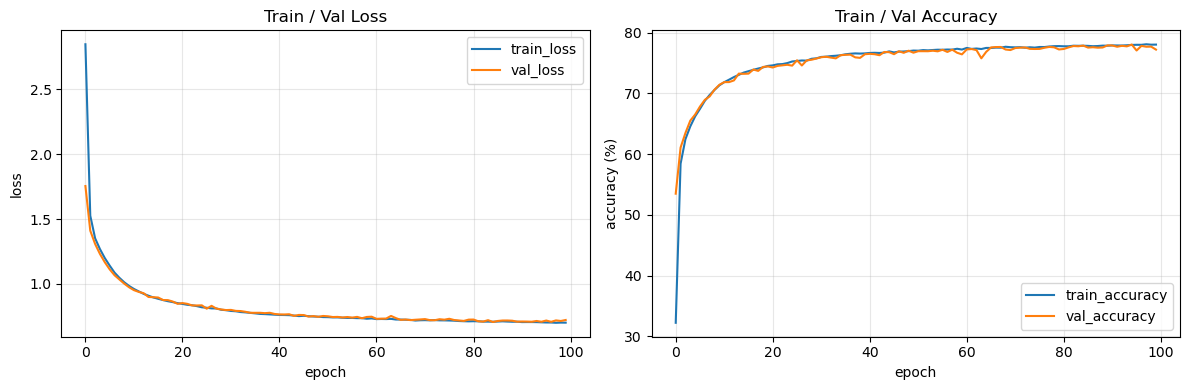

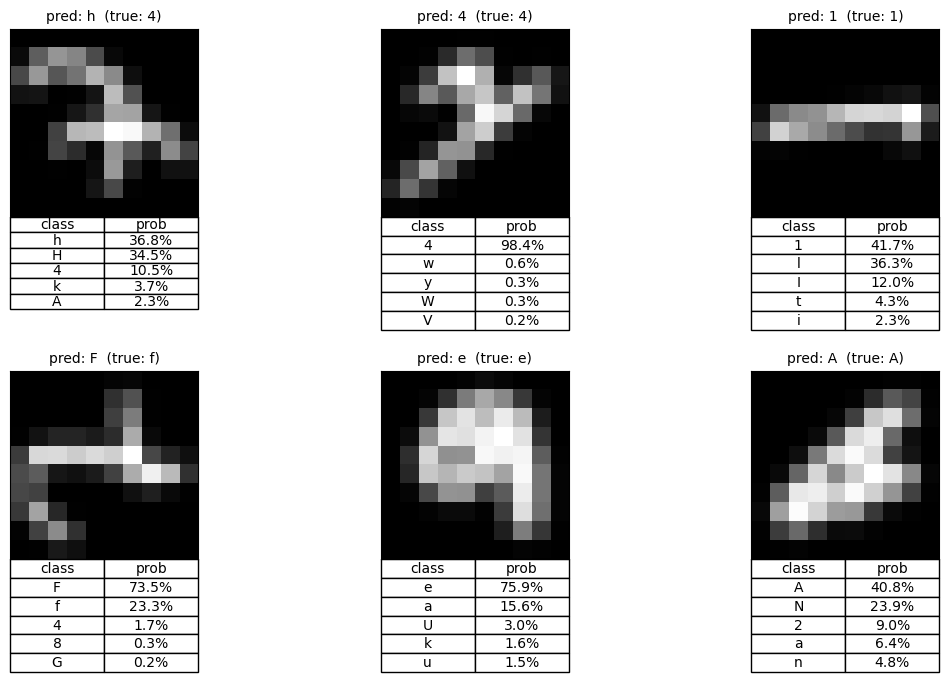

In [ ]:
# Example: MNIST

# Config
dataset_name: str = "emnist"
dataset_split: str = "byclass"
checkpoint_root: pathlib.Path = PROJECT_ROOT / "checkpoints"

# Train
result: dict[str, typ.Any] = train(
    dataset_name=dataset_name,
    dataset_split=dataset_split,
    epochs=100,
    batch_size=2048,
    lr=1e-3,
    depth=2,
    width=[32, 16],
    activations=["relu", "relu"],
    weight_bits=[8, 6, 6], # per Linear: 100->32, 32->16, 16->10
    activation_bits=[8, 8], # per activation
    project_root=PROJECT_ROOT,
    run_id=time.strftime("%Y%m%d_%H%M%S"),
    store_entire_model=True,
)

# Rebuild a test loader
_, test_ds, _, _ = load_dataset(
    name=dataset_name,
    split=dataset_split,
    project_root=PROJECT_ROOT,
    download_if_missing=False,
    chinese_root=None,
)
test_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=256,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)

# Export to C header (INT)
model = result["model"]
num_classes: int = len(result["class_names"])

# Export int Header
int_bits: list[int] = [int(b) if (b is not None) else 8 for b in (q.bits for q in model.wquants)]
header_out: pathlib.Path = PROJECT_ROOT / "python" / f"{dataset_name}_{dataset_split}_{time.strftime('%Y%m%d_%H%M%S')}_int.h"
export_model_to_header(
    result["model"],
    num_classes=num_classes,
    out_path=PROJECT_ROOT/"python"/"weights_int.h",
    mode="int",
    int_bits=int_bits,
)
print(f"[export] wrote {header_out}")

# Export float header
header_float_out: pathlib.Path = PROJECT_ROOT / "python" / f"{dataset_name}_{dataset_split}_{time.strftime('%Y%m%d_%H%M%S')}_float.h"
export_model_to_header(
    model=model,
    num_classes=num_classes,
    out_path=header_float_out,
    mode="float",
)

# Plots
plot_results(result["history"])
show_random_predictions(
    model=result["model"],
    loader=test_loader,
    class_names=result["class_names"],
    device=result["device"],
    n=6,
    k_top=5,
)